    Age Primary streaming service  Hours per day While working  \
0  18.0                   Spotify            4.0            No   
1  61.0             YouTube Music            2.5           Yes   
2  18.0                   Spotify            4.0           Yes   
3  18.0                   Spotify            5.0           Yes   
4  18.0             YouTube Music            3.0           Yes   

  Instrumentalist Composer         Fav genre Exploratory Foreign languages  \
0              No       No  Video game music          No               Yes   
1              No      Yes              Jazz         Yes               Yes   
2              No       No               R&B         Yes                No   
3             Yes      Yes              Jazz         Yes               Yes   
4             Yes       No  Video game music         Yes               Yes   

     BPM  ...  K pop_frequency  Latin_frequency  Lofi_frequency  \
0  132.0  ...                3                0               2   


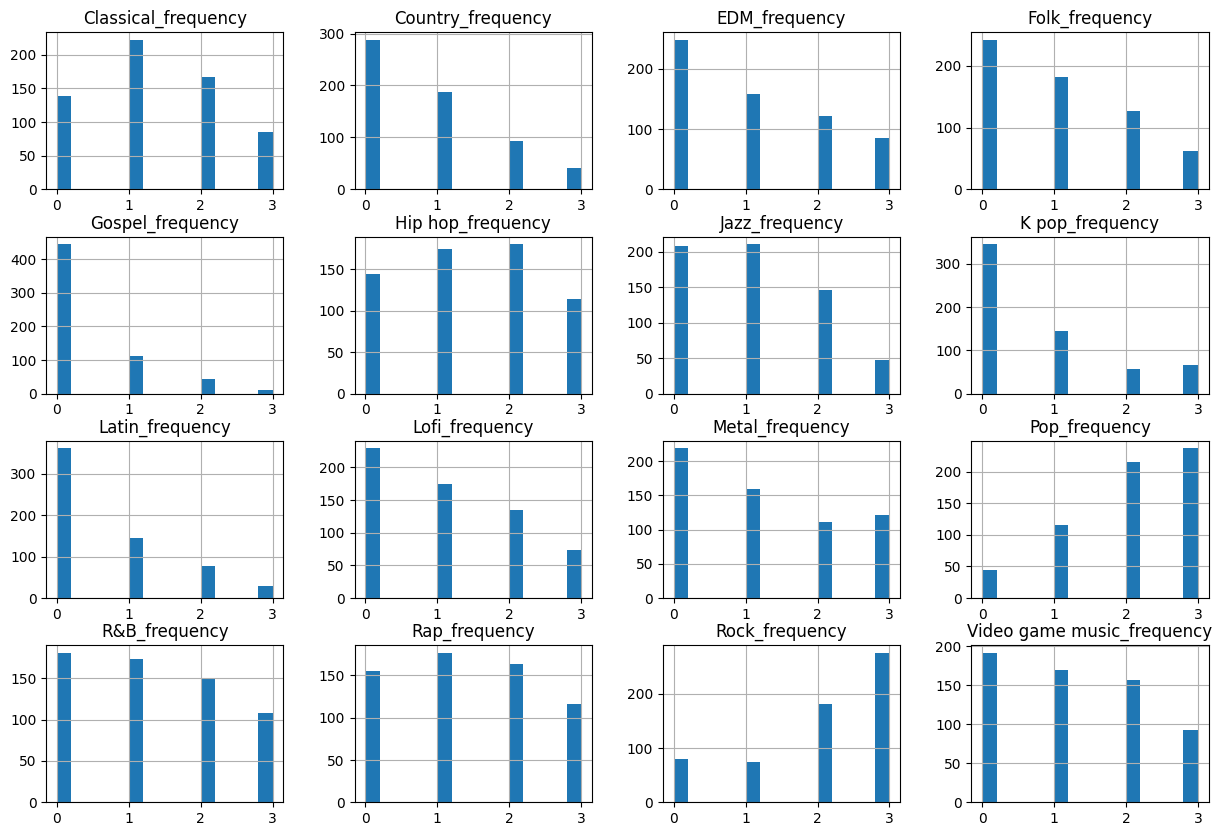

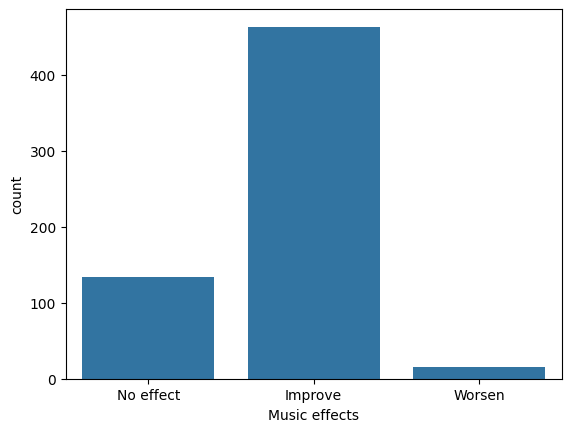

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb 
import json

# Carregando dataset
file_path = 'data/dados_tratados_V2.csv'
data = pd.read_csv(file_path, delimiter=';')

# Informações iniciais
print(data.head())
print(data.info())

# Visualização da distribuição dos estilos musicais
style_columns = [col for col in data.columns if 'frequency' in col]
data[style_columns].hist(bins=15, figsize=(15, 10))
plt.show()

# Verificar relação entre gêneros musicais e "Music effects"
sns.countplot(x='Music effects', data=data)
plt.show()

# Limpeza e preparação dos dados
data_clean = data.dropna(subset=['Music effects'])

# Mapeando "Music effects" para valores numéricos
data_clean['Music effects'] = data_clean['Music effects'].map({'Improve': 2, 'No effect': 1, 'Worsen': 0})

# Define X e y
X = data_clean[style_columns + ['Anxiety', 'Depression', 'Insomnia', 'OCD', 'Age']]
y = data_clean['Music effects']

# Balancear os dados com SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Definir treinamento e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Definição de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # para lidar com desbalanceamento
}

# Treinamento do modelo
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1
)
grid_search.fit(X_train, y_train)

# Parâmetros melhor avaliados
best_model = grid_search.best_estimator_
print("Melhores parâmetros:", grid_search.best_params_)

# Métricas
y_pred = best_model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Previsto']), annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusão")
plt.show()

# Árvore de decisão
#plt.figure(figsize=(75, 50))
#xgb.plot_tree(best_model, num_trees=0)
#plt.title('Visualização da Árvore de Decisão do Modelo XGBoost')
#plt.show()

classification_rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

precision_per_class = {
    int(cls): metrics['precision']
    for cls, metrics in classification_rep.items() if cls.isdigit()  # Filtrar apenas classes numéricas
}

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": classification_rep['macro avg']['precision'],  # Média macro
    "precision_per_class": precision_per_class
}

import joblib
joblib.dump(best_model, 'models/decision-tree-classifier-xgboost.pkl')

with open('metrics/decision-tree-classifier-xgboost.json', 'w') as metrics_file:
    json.dump(metrics, metrics_file, indent=4)